stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('data/gradients.csv')

In [7]:
df.head()

,subject,epoch,region,7net,17net,g1,g2,g3,g4,ecc
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042,-0.668984,1.732833
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047,-0.758676,1.978984
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822,0.007569,1.954366
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447,-0.858037,3.257601
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117,0.278002,1.298746


# ttests
compare `ecc` values between epochs. False discovery rate (FDR) correction applied.

In [8]:
import pingouin as pg

In [9]:
from matplotlib import pyplot as plt

In [10]:
dfpair = df.groupby(['region', '7net', '17net']).apply(
    pg.pairwise_tests, dv='ecc', subject='subject', padjust='fdr_bh',
    within='epoch'  # within instead of between, makes it paired
    )

In [11]:
# longer name for variable with big computation

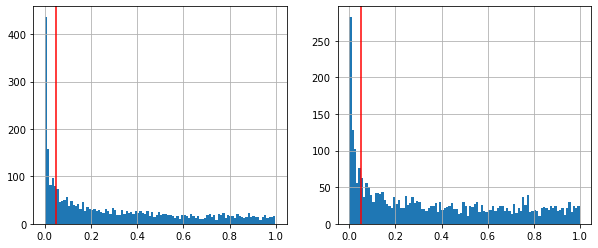

In [12]:
# fdr corrected on right panel
_, ax = plt.subplots(ncols=2, figsize=(10,4))
dfpair['p-unc'].hist(bins=100, ax=ax[0]) # uncorrected p value
ax[0].axvline(x=.05, color='red') # type-I error
dfpair['p-corr'].hist(bins=100, ax=ax[1]) # corrected p value
ax[1].axvline(x=.05, color='red') # type-I error
plt.show()

In [13]:
region_names = pd.read_csv('data/regions_sorted.csv')['region']

In [67]:
# epoch pairs set to be index
dfp = dfpair.reset_index(3)
dfp = dfp.set_index(['A', 'B'], append=True)
dfp = dfp.loc[region_names][['T', 'p-unc', 'p-corr']]
dfp['T'] = -1 * dfp['T']    # change t-statistics, look at appendix
dfp = dfp.reorder_levels([3,4,0,1,2])

dfp.loc[('baseline', 'early'), 'contrast'] = 'b2e'
dfp.loc[('early', 'late'), 'contrast'] = 'e2l'
dfp = dfp[~dfp['contrast'].isna()]  # drop baseline 2 late

dfp = dfp.droplevel([0,1])
dfp = dfp.set_index('contrast', append=True)
dfp = dfp.reorder_levels([3,0,1,2])
dfp

,,,,T,p-unc,p-corr
contrast,region,7net,17net,,,
b2e,7Networks_LH_Vis_1,Vis,DorsAttnA,-0.669191,0.507764,0.507764
e2l,7Networks_LH_Vis_1,Vis,DorsAttnA,-0.957059,0.345102,0.507764
b2e,7Networks_LH_Vis_2,Vis,VisCent,-0.756937,0.454153,0.454153
e2l,7Networks_LH_Vis_2,Vis,VisCent,1.991186,0.054311,0.162934
b2e,7Networks_LH_Vis_3,Vis,DorsAttnA,-1.259073,0.216337,0.324505
...,...,...,...,...,...,...
e2l,Right Hippocampus,Striatum,StriatumRight,-0.167146,0.868217,0.868217
b2e,Right Amygdala,Striatum,StriatumRight,1.990483,0.054392,0.124821
e2l,Right Amygdala,Striatum,StriatumRight,-0.635019,0.529546,0.529546


### non-masked

In [15]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot

In [16]:
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


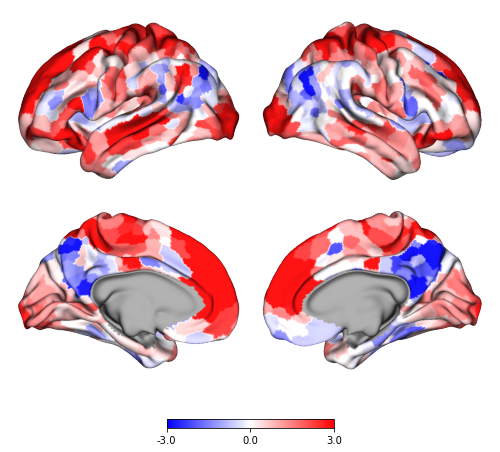

In [68]:
data = dfp.loc['b2e'].reset_index()['T']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

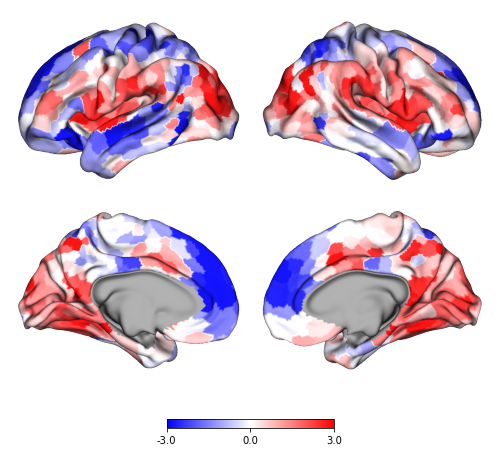

In [69]:
data = dfp.loc['e2l'].reset_index()['T']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

### masked with FDR pvalue

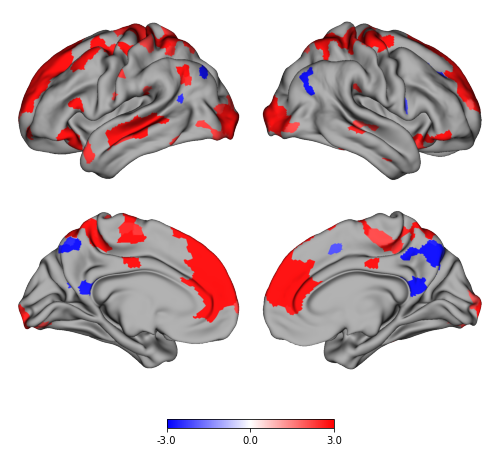

In [73]:
data = dfp.loc['b2e']
data = data.apply(lambda r: r['T'] if r['p-corr'] < 0.05 else None, axis=1).values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

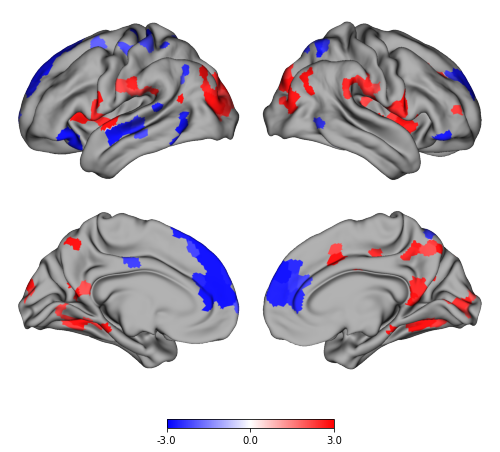

In [74]:
data = dfp.loc['e2l']
data = data.apply(lambda r: r['T'] if r['p-corr'] < 0.05 else None, axis=1).values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

# anova
repeated measures

In [75]:
df

,subject,epoch,region,7net,17net,g1,g2,g3,g4,ecc
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042,-0.668984,1.732833
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047,-0.758676,1.978984
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822,0.007569,1.954366
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447,-0.858037,3.257601
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117,0.278002,1.298746
...,...,...,...,...,...,...,...,...,...,...
109291,46,late,Right Putamen,Striatum,StriatumRight,-0.861413,-0.664291,-0.450307,-1.694324,2.063208
109292,46,late,Right Pallidum,Striatum,StriatumRight,-0.530126,-0.774942,-0.468807,-1.149747,1.556685
109293,46,late,Right Hippocampus,Striatum,StriatumRight,-0.938860,-0.247830,-1.223909,-1.464685,2.141526
109294,46,late,Right Amygdala,Striatum,StriatumRight,-1.114832,-0.355354,-1.374354,-1.242685,2.191402


In [76]:
dfa = df.groupby(['region', '7net', '17net']).apply(pg.rm_anova, dv='ecc',
                                      within='epoch', subject='subject')

In [78]:
_, dfa['p-corr'] = pg.multicomp(dfa['p-unc'], method='fdr_bh')

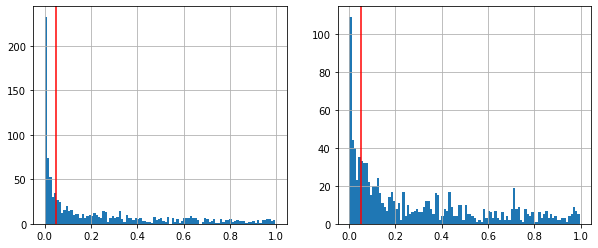

In [79]:
_, ax = plt.subplots(ncols=2, figsize=(10,4))
dfa['p-unc'].hist(bins=100, ax=ax[0]) # uncorrected p value
ax[0].axvline(x=.05, color='red') # type-I error
dfa['p-corr'].hist(bins=100, ax=ax[1]) # corrected p value
ax[1].axvline(x=.05, color='red') # type-I error
plt.show()

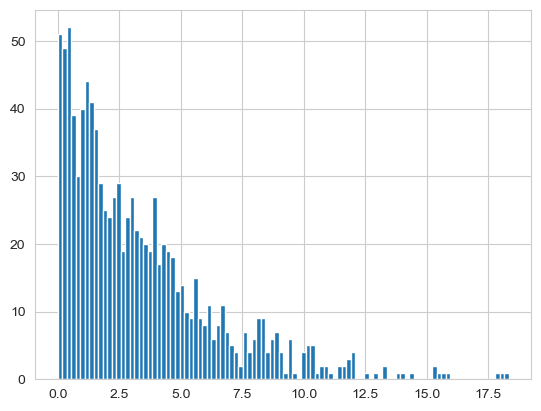

In [169]:
dfa['F'].hist(bins=100)
plt.show()

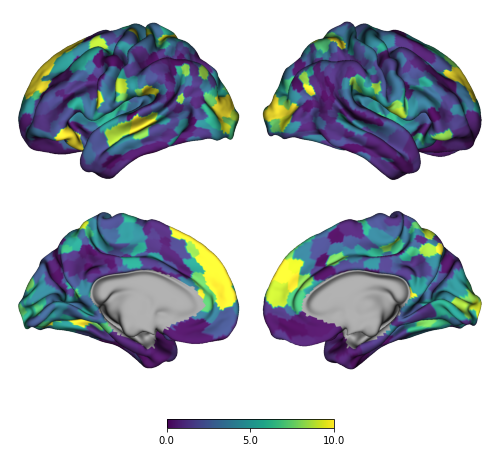

In [80]:
data = dfa.loc[region_names]['F'].values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='viridis', color_range=(0, 10))
_ = p.build()

masked with p value corrected

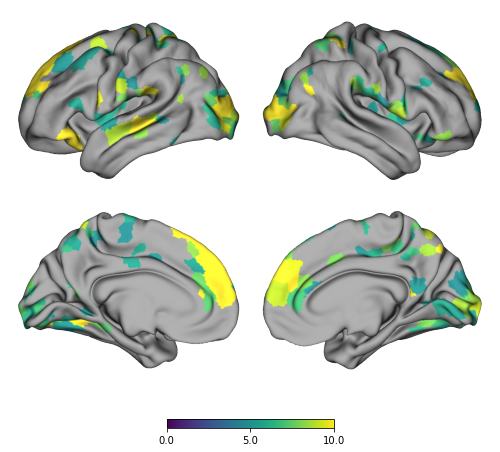

In [81]:
data = dfa.loc[region_names]
data = data.apply(lambda r: r['F'] if r['p-corr'] < 0.05 else None, axis=1).values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='viridis', color_range=(0, 10))
_ = p.build()

appendix: how to interpret t-tests results

In [83]:
d = df.set_index(['region','epoch',  'subject'])[['ecc']]
d = d.loc['7Networks_LH_Cont_Cing_1']
d

ecc
epoch    subject          
baseline 1        1.579930
         2        3.517658
         3        2.335139
         4        1.927699
         6        1.844896
...                    ...
late     40       0.716461
         41       2.868869
         44       1.658464
         45       2.473592
         46       3.201352

[108 rows x 1 columns]

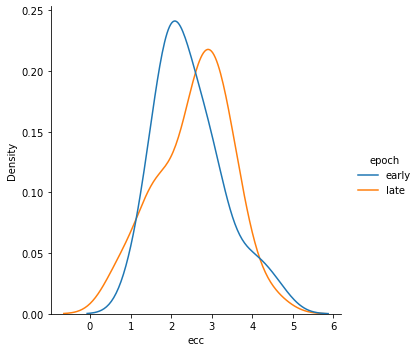

In [84]:
import seaborn

seaborn.displot(d.iloc[36:], hue='epoch', x='ecc', kind='kde')

In [85]:
d=d.unstack(0)['ecc']
d

epoch,baseline,early,late
subject,,,
1,1.579930,2.510811,3.351414
2,3.517658,3.823488,2.389208
3,2.335139,1.983248,1.571522
4,1.927699,2.389032,2.718790
6,1.844896,2.818948,0.990385
7,3.536721,1.781280,1.582131
8,1.685159,1.928411,2.518372
9,2.541401,1.605992,2.408289
10,2.163047,2.149965,3.746296


In [89]:
pg.ttest(d['late'],d['early'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.512925,35,two-sided,0.611226,"[-0.32, 0.54]",0.125782,0.202,0.113665


In [87]:
pg.ttest(d['late']-d['early'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.512925,35,two-sided,0.611226,"[-0.32, 0.54]",0.085487,0.202,0.078978
